# Energy Demand Prediction Model
## Introduction
In the energy industry, energy demand prediction is very important. A good energy demand prediction can largely reduce operation cost and emission levels. Energy prediciton is also vital for the secury energy supply because the model has smaller uncertainties, thus securing the planning and operation of energy facilities.  <br /> 
District heating is a subsector of the energy industry. The employment of advanced prediction algorithms is limited in the this sector. The current method to predict heat demand is a method called 'Energy Signature' that the relationship of outside temperature and energy demand is used to predict the energy demand at given outside temperature. However, the energy demands are influenced by many other factors. Among them, time plays an important role. Generally, there are morning peaks and evening peaks with residential buildings. Office buildings and industry uses more heat during the working hours. Thus, it would be necessary to include timestamps as the input to the energy prediction model. 
<br /> 
A model that takes into account of both weather and time is necessary for the accurate prediction of future energy demands. This notebook aims to fill the current gap through evalutating different prediciton models using neural networks, linear regression and decision trees and to compare these models with the existing energy signature model. 

### Problem Statement
The energy prediction model should use collected training data to train and validate a regression model that can predict energy demands at given timestamp and weather information. The performance of the trained model should be significantly better than the used 'Energy Signature Model', which is commonly used today in the industry. 

### Dataset
This project is based on the following dataset:
* Public holidays, which is collected manually. 
* Time-series weather data between 2017-2019, including temperature, wind speed, humidity, and radiation. The dataset is in 1 hour interval and is downloaded from [SMHI](https://www.smhi.se/q/Stockholm/2673730). 
* Time-series heat demand of several buildings at the same time period. The data is from E.ON and has been aggregated and processed to avoid disclosure of customer information. 

### Method
Four models will be trained and compared. 
* Energy Signature
* Multi Linear Regression
* Neural Network
* Decision Trees

Two methods to process timestamp data will be compared.
* Convert month/day/day of year, etc into categories. 
* Convert month/day/day of year, etc into trigonometric functions. 

### Metric
The energy prediction problem is to train regression models. We use **Root Mean Square Error** (RMSE) as the KPI to compare different methods and models. 


### Expected Outcome
The outcome of the project will be a energy prediciton model and a ready-to-use web application that can visualize the prediction. 


## import all necessary modules

In [1]:
# import all modules. 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import optimize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model

## Merge the data and prepare the dataset. 
The data that will be used is stored in the folder 'data', which includes the following files:
* Meter_Data.xlsx: Heat consumption
* Public holidays.xlsx: contains the days of public holidays, not including weekends. 
* SMHI.xlsx: Weather data. 
<br />
<br />
A glimpse of all raw data sets:
* The timestamp in 'Meter_Data.xlsx' is the Swedish local time, which includes winter and summer time. When changing from winter time to summer time, there is one timestamp has no data. When chaning from summer time to winter time, there will be one hour that has two hours head demand. The energy demand at the specific timestamp represents the hour from that timestamp. 
* The weather data uses the UTC time, which does not include summer time and winter time. The values at the specific timestamp represents the monment value at that timestamp. We need to get the average value between the two timestamps to repsent the weather for the hour between these two timestamps. 

The following functions solves the problems and prepare the dataset for further use. The process data set is saved to a csv file for later use.     

### Merge the data into one dataset

In [2]:
# merge the data from different excles into a dataframe 
# Save the dataframe to local csv file for later use use
def read_data():
    '''
    Read in dataset and return seperate dataframes

    Returns
    -------
    Temp : pandas.dataframe
        Temperture at different timestamps.
    Wind : pandas.dataframe
        Wind speed at different timestamps.
    Humi : pandas.dataframe
        Humidity at different timestamps.
    Radi : pandas.dataframe
        Solar radiation at different timestamps.
    pub_holidays : pandas.dataframe
        Dates that are public holidays, not including weekends.
    df_DISA : pandas.dataframe
        Energy demands of the hour after the specific timestamp.(Swedish local time)

    '''
     
    Temp = pd.read_excel('data\\SMHI.xlsx',
                         sheet_name = 'Temperature')
    Wind = pd.read_excel('data\\SMHI.xlsx',
                         sheet_name = 'Wind')
    Humi = pd.read_excel('data\\SMHI.xlsx',
                         sheet_name = 'Humidity')
    Radi = pd.read_excel('data\\SMHI.xlsx',
                         sheet_name = 'Radiation')
    pub_holidays = pd.read_excel('data\\Public holidays.xlsx')
    
    df_DISA = pd.read_excel('data\\Meter_Data.xlsx')
    
    return Temp, Wind, Humi, Radi, pub_holidays, df_DISA

def value_timestamp(df_weather, keyword, UTC_time):
    '''
    Based on the time to return average value between two timestamps. 

    Parameters
    ----------
    df_weather : pandas.dataframe
        A dataframe that holds the weather information. 
    keyword : string
        Column name of the df_weather
    UTC_time : TYPE
        The UTC timestamp of the beginning hour. 

    Returns
    -------
    Value_hour : float
        Averate Weather data between UTC_time and UTC_time+1 

    '''
    
    S_temp = df_weather.loc[df_weather['Time (UTC)'] == UTC_time, keyword]
    E_temp = df_weather.loc[df_weather['Time (UTC)'] == (UTC_time + pd.Timedelta(hours=1)) , keyword]
    if len(S_temp) >0 and len (E_temp)>0:
        Value_hour = (S_temp.to_list()[0] + E_temp.to_list()[0])/2
    elif len(S_temp) >0 :
        Value_hour = S_temp.to_list()[0]
    elif len(E_temp) >0 :
        Value_hour = E_temp.to_list()[0]
    else:
        Value_hour = np.nan
    return Value_hour

def value_DISA(df_Meter, time, col):
    '''
    Return Meter_data values. 

    Parameters
    ----------
    df_Meter : pandas.dataframe
        The energy demand dataset, which include heat demand, flow demand, supply T and return T. 
    time : dataframe.timestamp
        The local time. 
    col : string
        Column name. Example: 'Energi (kWh)', 'Volym (m3)', 'framtemp (°C)', 'returtemp (°C)'

    Returns
    -------
    Value : float
        The value of 'col' at 'time'

    '''
    
    summer_to_winter_time = [pd.Timestamp(2017,10,29,2),
                             pd.Timestamp(2018,10,28,2),
                             pd.Timestamp(2019,10,27,2)]
    
    if time in summer_to_winter_time and col == 'Energi (kWh)':
        div = 2
    else:
        div = 1
    
    
    df_temp = df_Meter.loc[df_Meter['Time'] == time, col].copy()
    if len(df_temp) > 0:
        Value = df_temp.to_list()[0]/div
    else:
        Value = np.nan
    return Value

def check_holiday(df_holiday, time):
    '''
    Check if the given time is a public holiday

    Parameters
    ----------
    df_holiday : pandas.dataframe
        A dataframe that includes the days that are public holidays
    time : pandas.Timestamp
        A timestamp that we need to check if it is a public holiday

    Returns
    -------
    check_ho : int, 1 or 0

    '''
    
    weekday = time.isoweekday()
    date = time.date()
    date_s = df_holiday['Date'].tolist()
    date_s_list = [xx.date() for xx in date_s]
    
    if date in date_s_list or weekday in [6,7]:
        check_ho = 1
    else:
        check_ho = 0
    
    return check_ho

def make_dataset():
    '''
    A function to preprare the data set for Machine learning. 
    Save to a local file. 
    Returns
    -------
    df_Data : pandas.dataframe
        DESCRIPTION.

    '''
    print ('preparing the dataset for energy prediciton model')
    # read in data from excel files. 
    T, W, H, R, Holiday, Meter = read_data()
    
    # try to use average value instead of a single value. 
    columns = ['CET_time_as_Meter','Year','Month', 'Day', 'Day of year', 
               'Hour of day' ,'Weekday', 'if_Holiday', 
               'Temperature', 'Wind Speed', 'Humidity', 'Radiation', 
               'Energy', 'Flow', 'Return T']
    
    S_time = pd.Timestamp('2017-01-01T00', tz= 'CET')
    
    for ii in range (0,8760*3,1):
        # Time change
        CET_Time = S_time + pd.Timedelta(hours=ii) # DISA time example 00:00-01:00
        # to UTC time
        UTC_time = CET_Time.astimezone(tz='UTC').tz_convert(None)
        # CET time, delete timezone information
        Local_time = CET_Time.tz_localize(None)
        
        # Process data
        T_Hour = value_timestamp(T, 'Lufttemperatur' , UTC_time)
        W_Hour = value_timestamp(W, 'Vindhastighet' , UTC_time)
        H_Hour = value_timestamp(H, 'Relativ Luftfuktighet (%)' , UTC_time)
        R_Hour = value_timestamp(R, 'Global Irradians (W/m2)' , UTC_time)
        Energy_Hour = value_DISA(Meter, Local_time, 'Energi (kWh)')
        Flow_Hour = value_DISA(Meter, Local_time, 'Volym (m3)')
        ReturnT_Hour = value_DISA(Meter, Local_time, 'returtemp (°C)')
        
        Hour_data = np.array([[CET_Time,
                              CET_Time.year,
                              CET_Time.month,
                              CET_Time.day,
                              CET_Time.dayofyear,
                              CET_Time.hour,
                              CET_Time.isoweekday(),
                              check_holiday(Holiday, CET_Time),
                              T_Hour,
                              W_Hour,
                              H_Hour,
                              R_Hour,
                              Energy_Hour,
                              Flow_Hour,
                              ReturnT_Hour]])
        
        if ii == 0:
            Data_all = Hour_data
        else:         
            Data_all = np.append(Data_all, Hour_data, axis = 0)
            
    df_Data = pd.DataFrame(Data_all,
                           columns = columns)
    
    print ('data is saving to test_data.csv')
    df_Data.to_csv('data\\test_data.csv', index = False)
    return df_Data
df_input = make_dataset()

preparing the dataset for energy prediciton model
data is saving to test_data.csv


In [5]:
# Take a look at the merged dataset
df_input.head()


,CET_time_as_Meter,Year,Month,Day,Day of year,Hour of day,Weekday,if_Holiday,Temperature,Wind Speed,Humidity,Radiation,Energy,Flow,Return T
0,2017-01-01 00:00:00+01:00,2017,1,1,1,0,7,1,6.8,3,93,0,6510,133.711,41.4592
1,2017-01-01 01:00:00+01:00,2017,1,1,1,1,7,1,6.3,3,96,0,6616,133.96,41.7282
2,2017-01-01 02:00:00+01:00,2017,1,1,1,2,7,1,6.15,3,96.5,0,6478,134,42.2103
3,2017-01-01 03:00:00+01:00,2017,1,1,1,3,7,1,6.1,2.5,96,0,6659,136,42.2233
4,2017-01-01 04:00:00+01:00,2017,1,1,1,4,7,1,5.7,1.5,97,0,6414,135.93,42.5533


In [11]:
df_input[['Temperature', 'Wind Speed', 'Humidity', 'Radiation', 'Energy']].mean()

Temperature       7.127015
Wind Speed        3.252714
Humidity         77.885004
Radiation       117.583694
Energy         8273.777664
dtype: float64

In [12]:
df_input[['Temperature', 'Wind Speed', 'Humidity', 'Radiation', 'Energy']].std()

Temperature       8.419243
Wind Speed        1.851267
Humidity         19.056362
Radiation       191.432319
Energy         5480.633059
dtype: float64

In [9]:
# Check if there are missing values. 
df_input.loc[df_input.isna().sum(axis=1) > 0]

,CET_time_as_Meter,Year,Month,Day,Day of year,Hour of day,Weekday,if_Holiday,Temperature,Wind Speed,Humidity,Radiation,Energy,Flow,Return T
9275,2018-01-22 11:00:00+01:00,2018,1,22,22,11,1,0,NaN,NaN,NaN,69.05,19114,316.402,41.5937
9276,2018-01-22 12:00:00+01:00,2018,1,22,22,12,1,0,-7,NaN,NaN,69.915,19319,314.461,41.4453
9793,2018-02-13 01:00:00+01:00,2018,2,13,44,1,2,0,NaN,NaN,NaN,0,11741,194.412,42.9594
9794,2018-02-13 02:00:00+01:00,2018,2,13,44,2,2,0,NaN,NaN,NaN,0,11636,195.472,43.5255
9795,2018-02-13 03:00:00+01:00,2018,2,13,44,3,2,0,NaN,NaN,NaN,0,11790,197.741,43.4504
9796,2018-02-13 04:00:00+01:00,2018,2,13,44,4,2,0,NaN,NaN,NaN,0,11811,194.042,42.936
14319,2018-08-20 16:00:00+02:00,2018,8,20,232,16,1,0,NaN,NaN,NaN,174.91,1480,36.271,37.13
14320,2018-08-20 17:00:00+02:00,2018,8,20,232,17,1,0,NaN,NaN,NaN,237.135,1864,40.31,33.9951
14321,2018-08-20 18:00:00+02:00,2018,8,20,232,18,1,0,NaN,NaN,NaN,192.3,2032,45.02,33.1899
14322,2018-08-20 19:00:00+02:00,2018,8,20,232,19,1,0,14.5,NaN,NaN,105.88,2321,48.811,33.1077


### Impute the missing values. 
As can be seen from the last cell, there are serveral rows that have missing values. Here we use an approach 'yesterday as today' to impute the missing values. The following function will find the missing value and goes 24 hour backwards (or multiple days until it finds a value) to find the value to replace the missing value. The following part further saves the data into a local csv file. 

In [10]:
# Use a method 'yesterday as today' to impute the missing values. 
def impute_nan(df_input):
    df = df_input.copy()
    # make the first column to pd.Timestamp object
    df['CET_time_as_Meter'] = df['CET_time_as_Meter'].apply(pd.Timestamp)    
    # find all the row index and columns that have NaN values
    df_nan = df.loc[df.isna().sum(axis=1) > 0].copy()
    column_nan = df_nan.columns[df_nan.isna().sum()>0].tolist()
    # print (column_nan)

    for col_name in column_nan:
        for index, value in df_nan[col_name].items():    
            # if value exists, break
            if np.isnan(df.loc[index, col_name]) == False:
                continue

            # move backwards by day 
            current_time = df['CET_time_as_Meter'][index]
            dt = pd.Timedelta(days=-1)
            
            if_find = 0
            ii = 1
            while if_find==0:
                new_time = current_time + ii*dt
                new_data = df.loc[df['CET_time_as_Meter']==new_time][col_name].tolist()
                if len(new_data) > 0:                   
                    df.loc[index, col_name] = new_data[0]
                    if_find =1
                ii+=1
    df.to_csv('data\\data_impute.csv', index = False)
    return df

df_input = pd.read_csv('data\\test_data.csv') 
df_impute = impute_nan(df_input)

In [12]:
# Check if there are missing values. 
df_impute.loc[df_impute.isna().sum(axis=1) > 0]


,CET_time_as_Meter,Year,Month,Day,Day of year,Hour of day,Weekday,if_Holiday,Temperature,Wind Speed,Humidity,Radiation,Energy,Flow,Return T


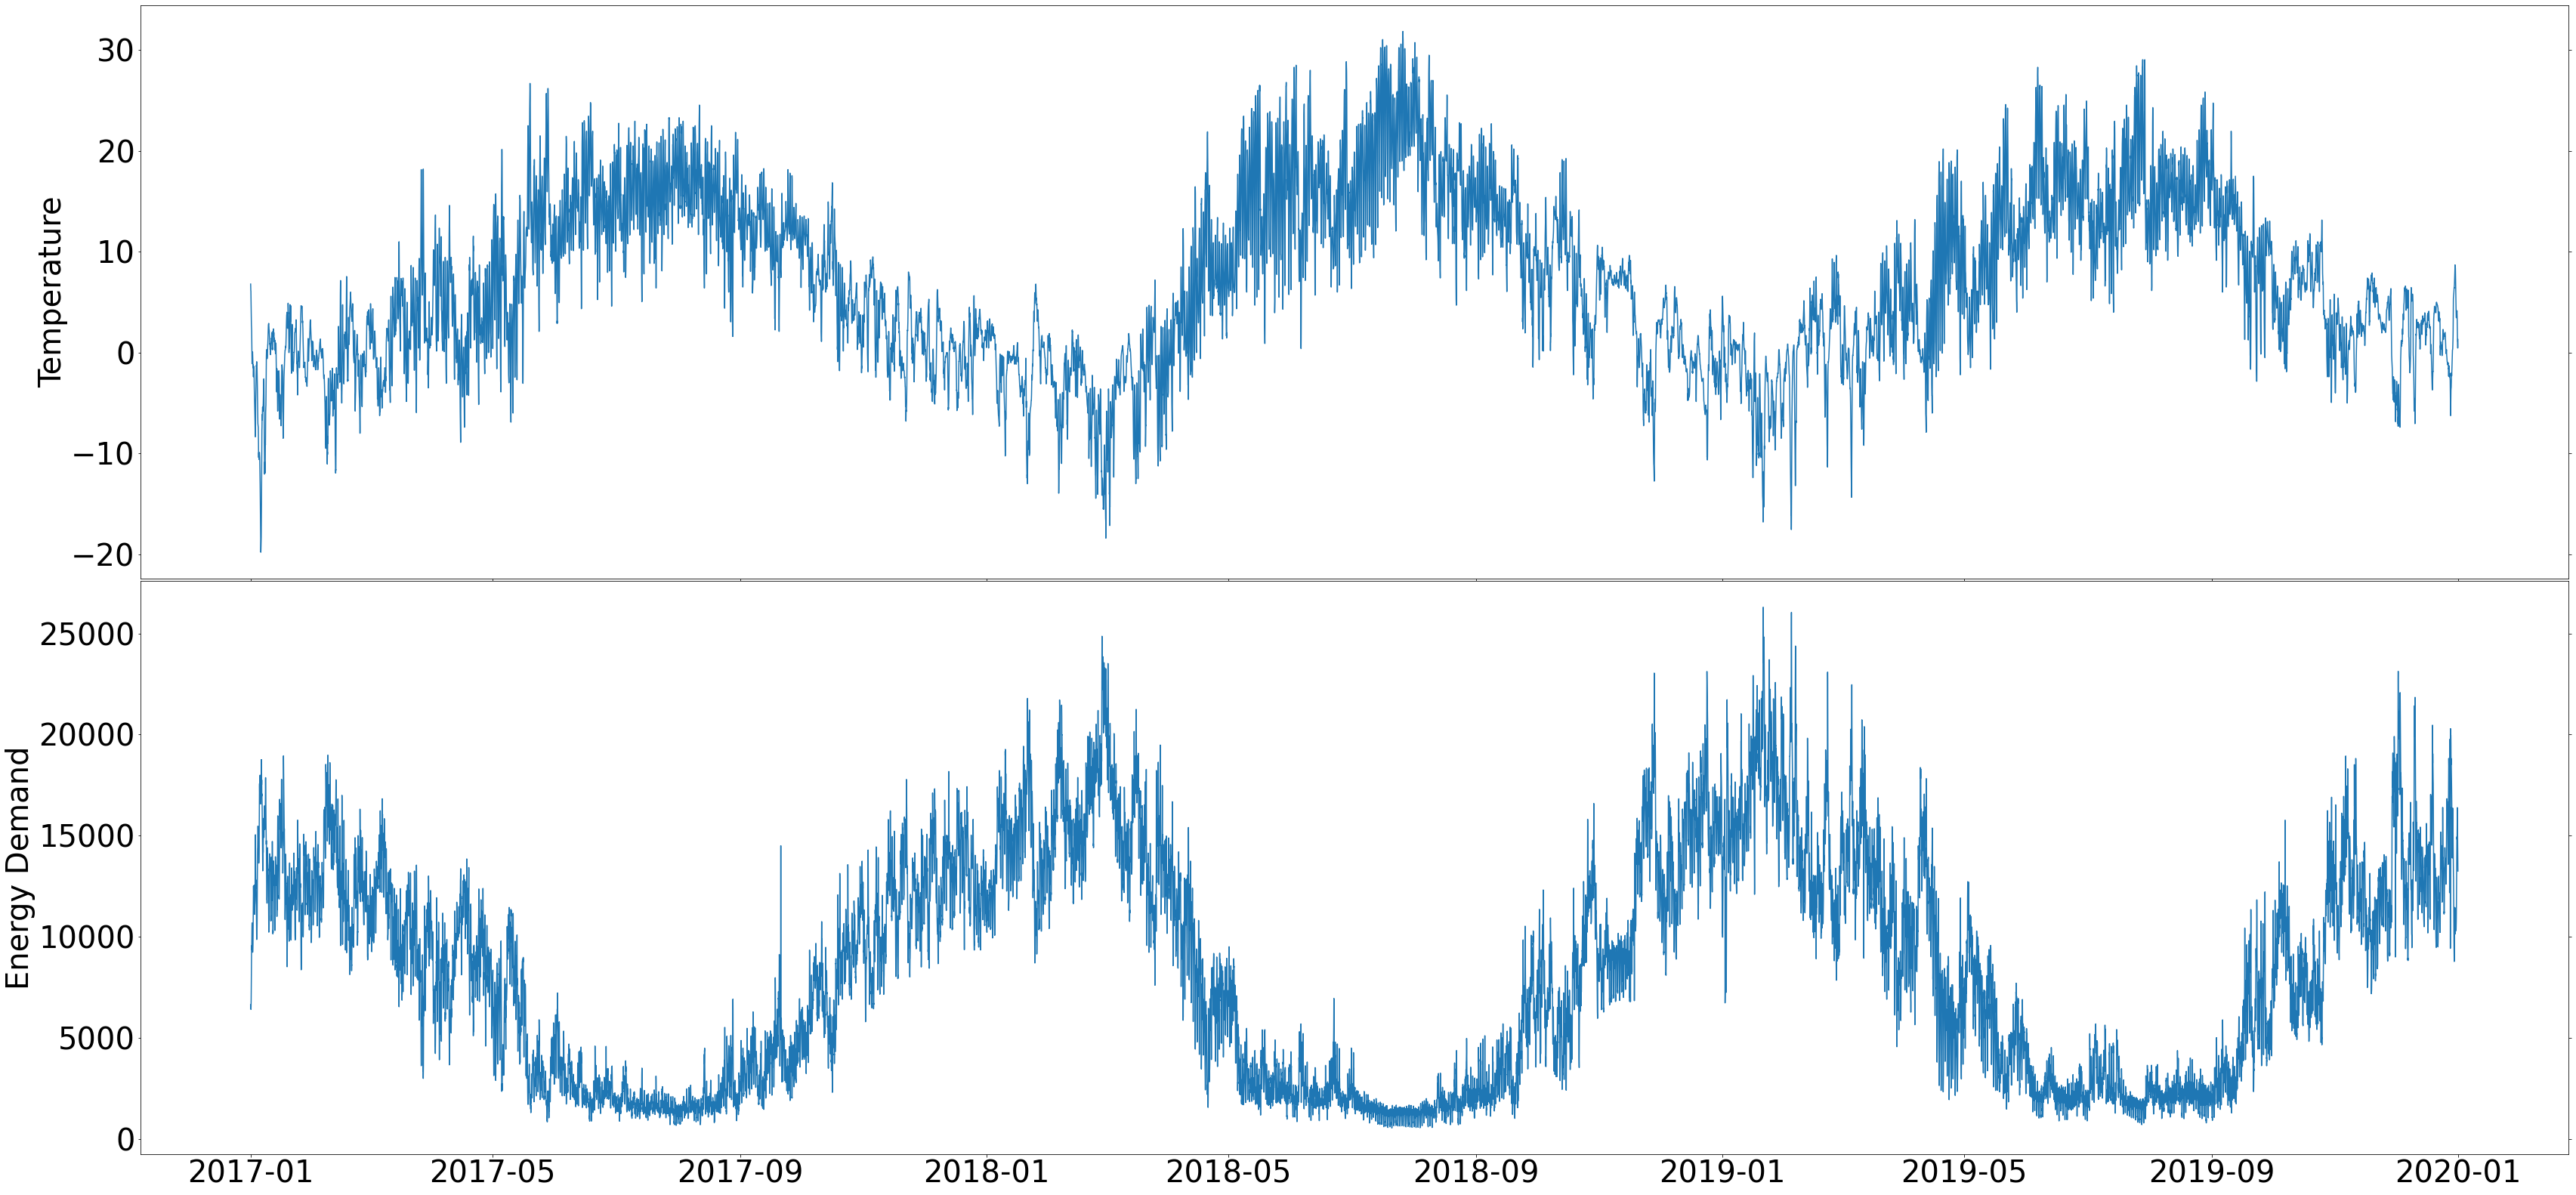

In [30]:
# Visualization of data
# Only show Temperature and Energy demand
fig=plt.figure()
fig.set_size_inches(w=(48),h=(24))
plt.subplots_adjust(left=0.05, right=0.98, top=0.98, bottom=0.1, hspace = 0.005)
ax1 = plt.subplot(2,1,1)
ax1.plot(df_impute['CET_time_as_Meter'], df_impute['Temperature'])
ax1.set_ylabel('Temperature',fontsize=40)
ax1.tick_params(axis='both', which='major', labelsize=40, right = True)

ax2 = plt.subplot(2,1,2)
ax2.plot(df_impute['CET_time_as_Meter'], df_impute['Energy'])
ax2.set_ylabel('Energy Demand',fontsize=40)
ax2.tick_params(axis='both', which='major', labelsize=40, right = True)
               

## Data Cleaning and Prepare Train and Test Dataset.
In this section, we will first process the time-related data. We employed two methods in this project to process time-related data: 
* Time as category input. For example, hour in a day are consecutive integers. We can convert them into dummy variables using pandas.
* Time as Sine and Cosine function. We can convert the time-related info into Sine and Cosine functions.  

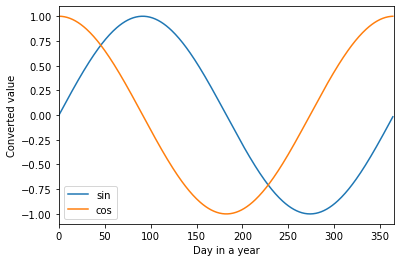

In [16]:
# An example of using Sine and Cosine function to represent day in a day. 
days = np.arange(0,365,1)
days_sin = np.sin(days * (2 * np.pi / 365))
days_cos = np.cos(days * (2 * np.pi / 365))
plt.plot(days,days_sin)
plt.plot(days,days_cos)
plt.xlabel('Day in a year')
plt.ylabel('Converted value')
lims = [0, 365]
plt.xlim(lims)
plt.legend(['sin', 'cos'])
plt.show()

In [2]:
# This section defines the functions needed to prepare the data by two differnet methods as well as functions
# to do standardlization and train test split. 

def time_info_as_dummies(data):
    '''
    A function to convert time-related columns into categorical columns. 

    Parameters
    ----------
    data : pandas.dataframe
        Input dataframe to process
    Returns
    -------
    datset : pandas.dataframe
        dataframe that have been processed
    '''
    
    # Columns to get_dummies
    Col_dummy = ['Day of year', 'Weekday', 'Month', 'Day', 'Hour of day']
    dataset = pd.get_dummies(data, prefix=Col_dummy, columns = Col_dummy)    
    
    # return a dataframe.
    return dataset


def time_info_as_sin_cos(data):
    '''
    A function to convert time-related columns into Sine and Cosine values

    Parameters
    ----------
    data : pandas.dataframe
        Input dataframe to process
    Returns
    -------
    datset : pandas.dataframe
        dataframe that have been processed
    '''
    
    # convert ['Day of year', 'Hour of day', 'Month', 'Day'] into sin and cos
    df = data.copy()
    day_of_year = np.array(df['Day of year'])
    df['day_of_year_sin'] =  np.sin(day_of_year * (2 * np.pi / 365))
    df['day_of_year_cos'] =  np.cos(day_of_year * (2 * np.pi / 365))

    hour_of_day = np.array(df['Hour of day'])
    df['hour_of_day_sin'] =  np.sin(hour_of_day * (2 * np.pi / 24))
    df['hour_of_day_cos'] =  np.cos(hour_of_day * (2 * np.pi / 24))

    month_of_year = np.array(df['Month'])
    df['month_of_year_sin'] =  np.sin(month_of_year * (2 * np.pi / 12))
    df['month_of_year_cos'] =  np.cos(month_of_year * (2 * np.pi / 12))

    day_of_month = np.array(df['Day'])
    df['day_of_month_sin'] =  np.sin(day_of_month * (2 * np.pi /31))
    df['day_of_month_cos'] =  np.cos(day_of_month * (2 * np.pi /31))

    day_of_week = np.array(df['Weekday'])
    df['day_of_week_sin'] =  np.sin(day_of_month * (2 * np.pi /7))
    df['day_of_week_cos'] =  np.cos(day_of_month * (2 * np.pi /7))

    # Delete the original rows. 
    df.drop(['Day of year', 'Hour of day', 'Month', 'Day', 'Weekday'], 
            axis = 'columns', inplace = True)
    
    # return a dataframe
    return df

# Normalize
def normalize(X_train, X_test, Col_Norm, if_save_scaler = False):
    '''
    A function to normalize the train and test data, based on scikit learn

    Parameters
    ----------
    X_train : TYPE
        The train dataset
    X_test : TYPE
        The test dataset
    Col_Norm : list
        List of columns to be normalized. 
    if_save_scaler : True or False
        Option to save the scaler. If True, the standard scaler is saved to a local file
    Returns
    -------
    X_train_array : numpy.array
        The converted train datast
    X_test_array : numpy.array
        The converted test datast
    X_col_indice: dictionary
        A dictionary that hold the column names of X_train_array and corresponding rows. 

    '''
    # seperate the train and test by columns that should be normalized. 
    X_train_Norm_Col = X_train[Col_Norm]
    X_train_other = np.array(X_train.drop(Col_Norm, axis = 'columns'))
    X_test_Norm_Col = X_test[Col_Norm]
    X_test_other = np.array(X_test.drop(Col_Norm, axis = 'columns'))

    # Get two dics that holds the columns names and indices
    X_col_indice_1 = {name:i for i, name in enumerate(X_train_Norm_Col.columns)}
    Other_columns = X_train.drop(Col_Norm, axis = 'columns').columns
    X_col_indice_2 = {name:(i+len(X_train_Norm_Col.columns)) for i, name in enumerate(Other_columns)}

    # Use scikit-learn to normalize the data
    scaler = StandardScaler()
    X_train_norm_array = scaler.fit_transform(X_train_Norm_Col)
    X_test_norm_array = scaler.transform(X_test_Norm_Col)
    
    if if_save_scaler == True:
        print ('saving the standard scaler...')
        pickle.dump(scaler, open('models/scaler.pkl .', 'wb'))
        
    
    # Append the two parts and make two arrays. 
    X_train_array = np.append(X_train_norm_array, X_train_other, axis = 1)
    X_test_array = np.append(X_test_norm_array, X_test_other, axis = 1)

    # Merge the two indice dictionary together. 
    X_col_indice = {**X_col_indice_1, **X_col_indice_2}
    
    return X_train_array, X_test_array, X_col_indice


def split_and_normalize(data, method, weather_info, **kwargs):
    '''
    A function that combines the process of time related columns, split and standardlization.

    Parameters
    ----------
    data : pandas.dataframe
        The dataset to be precessed 
    method : string, dummy or sincos
        Choose the method to process the time-related columns. 
    weather_info : list
        List of weather information should be included in the training and test dataset. 
    
    Returns
    -------
    X_train_norm : numpy.array
        The train datast
    X_test_norm : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    y_test: numpy.array
        The labels of test data
    X_col_indice: dictionary
        A dictionary that hold the column names of X_train_array and corresponding rows. 

    '''
    
    if method not in ['dummy', 'sincos']:
        raise ValueError('please check the method')

    # drop irrelevent values. 
    df = data.copy()
    df.drop(['CET_time_as_Meter', 'Year', 'Flow', 'Return T'], 
            axis = 'columns', inplace = True)
    
    All_weather = ['Temperature', 'Wind Speed', 'Humidity', 'Radiation']
    weather_to_drop = [xx for xx in All_weather if xx not in weather_info]
    
    df.drop(weather_to_drop, 
            axis = 'columns', inplace = True)

    # Process the time info with two methods. 
    if method == 'dummy':
        df_time = time_info_as_dummies(df)
    else:
        df_time = time_info_as_sin_cos(df)
    
    # split df_time into X and y
    X = df_time.drop('Energy', axis = 'columns')
    y = df_time['Energy']
    # further split into train and test set
    # random states makes sure that the split is repeatly inspite of different X.
    # As long as the rows are fixed, the split x_train and x_test index should be repeatable. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # To normalize. 
    # define the columns to be normized and normalize the data.
    Col_Norm = weather_info
    X_train_norm, X_test_norm, X_col_indice = normalize(X_train, X_test, Col_Norm,**kwargs)

    return  X_train_norm, X_test_norm, y_train, y_test, X_col_indice



In [18]:
# test the above functions
df = pd.read_csv('data\\data_impute.csv')
X_train, X_test, y_train, y_test, X_col_indice = split_and_normalize(df, 'sincos', ['Temperature', 'Wind Speed', 'Humidity', 'Radiation'])

print (X_train.shape)
print (y_train.shape)

(17607, 15)
(17607,)


## Prediction Models
Four models will be used in this study:
* Energy signature model, built by using scipy
* Neural network model, built by using Keras.
* Multi linear regression, built by using scikit-learn
* Decision tree, built by using XGBoost. 

### Energy signature model
This is the most-used model in industry. It carried out a regression of outside temperature and heat demands by using break point analys. An example is given in the next cell.

### Neural network model
Neural networks have been very popular in recent years and have been used in many sectors. In this project, we will test a simple two layer neural networks. 

### Multi linear regression model
Multi lieanr regression is a simple machine learning algorithm and is good for catching linear relationships, as suggested by its name. It is not clear if this algorithm can be used in this problem. 

### Decision trees regression model
There are several articles that report that decision trees can be used for energy prediciton. 

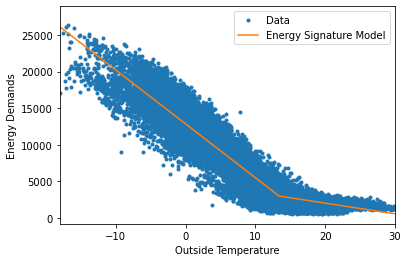

In [23]:
# The concept of Energy Signature. 
def ES_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
x = np.array(df['Temperature'])
y = np.array(df['Energy'])

p , e = optimize.curve_fit(ES_linear,x, y,
                            bounds =([10,3000,-np.inf , -np.inf],[16,6000,np.inf, np.inf]))
xx = np.arange(-20,30,0.1)
yy = ES_linear(xx, *p)

plt.plot(df['Temperature'], df['Energy'],'.')
plt.plot(xx,yy)
plt.xlabel('Outside Temperature')
plt.ylabel('Energy Demands')
lims = [-18, 30]
plt.xlim(lims)
plt.legend(['Data', 'Energy Signature Model'])
plt.show()

In [3]:
# This cell defines the models and visulization functions that would be later used. 

def energy_signature(X_train, X_test, y_train, X_col_indice):
    '''
    Build up the energy signature model. 
    Train the model based on the training dataset. 
    Give predictions on the test dataset. 

    Parameters
    ----------
    X_train : numpy.array
        The train datast
    X_test : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    X_col_indice: dictionary
        A dictionary that hold the column names of X_train_array and corresponding rows.   
    
    Returns
    -------
    Y_pred_ES : numpy.array
        The precition on the test datset
    '''
    x = X_train[:,X_col_indice['Temperature']]
    y = y_train
    def ES_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    
    # Training the model.
    p , e = optimize.curve_fit(ES_linear, x, y,
                               bounds =([0.5,3000,-np.inf , -np.inf],[1.5,6000,np.inf, np.inf]))
    
    y_pred_ES = ES_linear(X_test[:,X_col_indice['Temperature']], *p)
    
    return y_pred_ES

# Keras Dense NN
def NN_keras(X_train, X_test, y_train):
    
    '''
    Build up the neural network model. 
    Train the model based on the training dataset. 
    Give predictions on the test dataset. 

    Parameters
    ----------
    X_train : numpy.array
        The train datast
    X_test : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    
    Returns
    -------
    Y_pred_NN : numpy.array
        The precition on the test datset
    history: 
        The training history

    '''
    
    def build_model():
        
        model = keras.Sequential([
                                layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
                                layers.Dense(64, activation='relu'),
                                layers.Dense(1)
                                ])

        optimizer = tf.keras.optimizers.RMSprop(0.001)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
        return model

    model = build_model()
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train,
                        batch_size = 200,
                        epochs=1000, 
                        validation_split = 0.2, 
                        verbose=0,
                        callbacks=[early_stop])
    
    y_pred_NN = model.predict(X_test).flatten()

    return y_pred_NN, history

# multiple linear regression
def linear_sklearn(X_train, X_test, y_train):
    '''
    Build up the multi linear regression model. 
    Train the model based on the training dataset. 
    Give predictions on the test dataset. 

    Parameters
    ----------
    X_train : numpy.array
        The train datast
    X_test : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    
    Returns
    -------
    Y_pred_linear : numpy.array
        The precition on the test datset

    '''
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    
    return y_pred_linear

# Train with xgboost
# reference: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
def xgboost_model(X_train, X_test, y_train, y_test):
    '''
    Build up the decision train model. 
    Train the model based on the training dataset. 
    Give predictions on the test dataset. 

    Parameters
    ----------
    X_train : numpy.array
        The train datast
    X_test : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    y_test: numpy.array
        The labels of test data
    
    Returns
    -------
    Y_pred_xgboost : numpy.array
        The precition on the test datset
    reg : 
        The trained regression model

    '''
    
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set = [(X_test, y_test)], 
            early_stopping_rounds=50,
            verbose=False)

    y_pred_xgboost = reg.predict(X_test)
    return y_pred_xgboost, reg

# define two methods to visualize the test results. 
def visualize(y_test, y_pred, model_name): 
    '''
    A method to visualize the test results. Scatter plot.  

    Parameters
    ----------
    y_test: numpy.array
        The true labels of test data
    y_pred: numpy.array
        The predicted values from the trained model
    '''
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    a = plt.axes(aspect='equal')
    plt.scatter(y_test,y_pred)
    plt.xlabel('True Values [Energy]')
    plt.ylabel('Predictions [Energy]')
    lims = [0, 35000]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.text(5000, 30000, model_name)
    plt.text(5000, 28000, 'RMSE:{:.0f}'.format(rmse))
    _ = plt.plot(lims, lims)
    plt.show()

def summary_pic(y_test, y_pred_list, model_names, file_name):    
    '''
    A method to visualize the summary results. Bar plot the RMSE value of each model  

    Parameters
    ----------
    y_test: numpy.array
        The true labels of test data
    y_pred_list: list of numpy.array
        Contains the predicted values from each model
    model_name: List
        A list of model names
    file_name: figure names to be saved
    '''
    
    rmse_list = []
    for y_pred in y_pred_list:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
    
    x = np.arange(len(y_pred_list))
    plt.bar(x,rmse_list)
    plt.xlabel('model')
    plt.ylabel('RMSE')
    plt.xticks(x, model_names)
    lims = [0, 2000]
    plt.ylim(lims)
    plt.savefig(file_name)
    plt.show()

## Results and Discussion
This presents the results and further select the methods that should be employed. The Metric that we use to compare different models and methods is **Root Mean Squared Error** (RMSE).
### Part I: Time info as dummy variables
Firstly, we treat time info as dummy variables and the following part gives the results of trained models. 

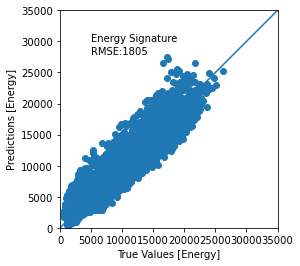

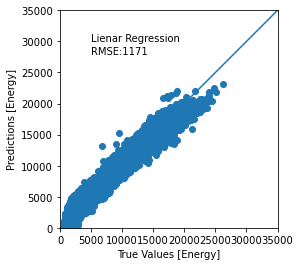

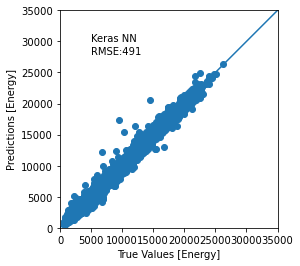

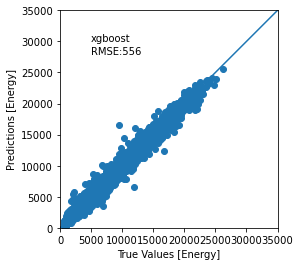

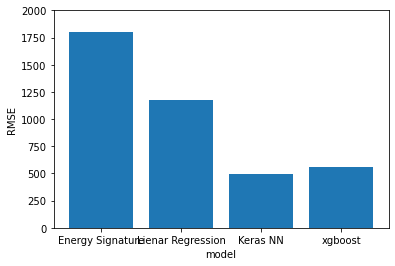

In [32]:
# Train the four models, use dummy date information
df = pd.read_csv('data\\data_impute.csv')
weather = ['Temperature', 'Wind Speed', 'Humidity', 'Radiation']
X_train, X_test, y_train, y_test, X_col_indice = split_and_normalize(df, 'dummy', weather)

y_pred_ES = energy_signature(X_train, X_test, y_train, X_col_indice)
y_pred_linear = linear_sklearn(X_train, X_test, y_train)
y_pred_NN, history = NN_keras(X_train, X_test, y_train)
y_pred_xgboost, xgboost_reg = xgboost_model(X_train, X_test, y_train, y_test)

# Visualize the four modeles. 
visualize(y_test, y_pred_ES, 'Energy Signature')
visualize(y_test, y_pred_linear, 'Lienar Regression')
visualize(y_test, y_pred_NN, 'Keras NN')
visualize(y_test, y_pred_xgboost, 'xgboost')

# A summary pic
y_pred_list = [y_pred_ES, y_pred_linear, y_pred_NN, y_pred_xgboost]
model_names = ['Energy Signature', 'Lienar Regression', 'Keras NN', 'xgboost']
summary_pic(y_test, y_pred_list, model_names, 'pics\\timeasdummy')

In this section, the neural network models achieve the best performance with the RMSE value of 491. 

### Part II: Time info as Sine and Cosine
We use Sine and Cosine function to convert time info. The following part gives the results of trained models

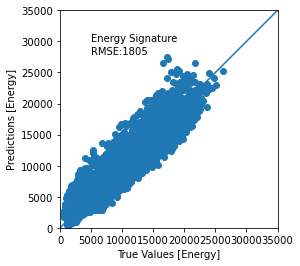

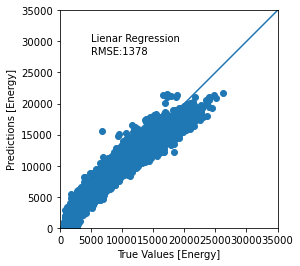

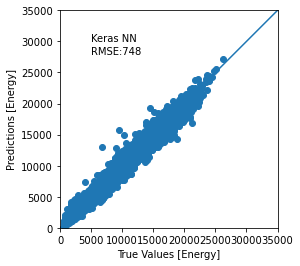

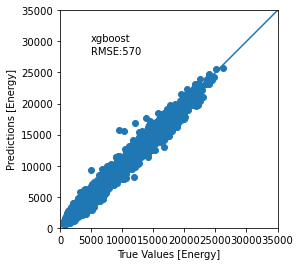

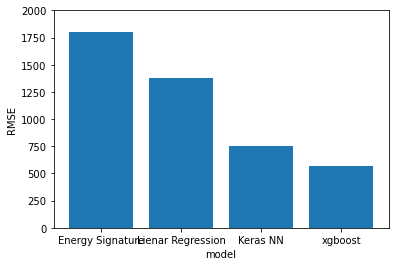

In [34]:
# Train the four models, use sin cos information
df = pd.read_csv('data\\data_impute.csv')
weather = ['Temperature', 'Wind Speed', 'Humidity', 'Radiation']
X_train, X_test, y_train, y_test, X_col_indice = split_and_normalize(df, 'sincos', weather)

y_pred_ES = energy_signature(X_train, X_test, y_train, X_col_indice)
y_pred_linear = linear_sklearn(X_train, X_test, y_train)
y_pred_NN, history = NN_keras(X_train, X_test, y_train)
y_pred_xgboost, xgboost_reg = xgboost_model(X_train, X_test, y_train, y_test)

# Visualize the four modeles. 
visualize(y_test, y_pred_ES, 'Energy Signature')
visualize(y_test, y_pred_linear, 'Lienar Regression')
visualize(y_test, y_pred_NN, 'Keras NN')
visualize(y_test, y_pred_xgboost, 'xgboost')

# A summary pic
y_pred_list = [y_pred_ES, y_pred_linear, y_pred_NN, y_pred_xgboost]
model_names = ['Energy Signature', 'Lienar Regression', 'Keras NN', 'xgboost']
summary_pic(y_test, y_pred_list, model_names, 'pics\\timeassincos')


In this section, the decision tree model (xgboost) has achieved the best result with RMSE value of 570. 
Overall, the combine of time info as dummy variables and neural network has the smallest RMSE value.

### Part III: Feature Selection
In the last two sections (Part I and II), we can know that the combination of neural network and time info as dummy variables yield the best results. However, the input information contains many weather information. In real applications, we might not be able to get these information. And the more information we need, the more costly the measurement system would be. <br /> 
In this section, we will discuss which feature is more imporant and check if we can only use part of the weather data. We use the XGBoost to present the feature importance. 

In [35]:
# use xgboost to show the most important features. 
df = pd.read_csv('data\\data_impute.csv')
weather = ['Temperature', 'Wind Speed', 'Humidity', 'Radiation']
X_train, X_test, y_train, y_test, X_col_indice = split_and_normalize(df, 'dummy', weather)
y_pred_xgboost, xgboost_reg = xgboost_model(X_train, X_test, y_train, y_test)

print(len(xgboost_reg.feature_importances_))

# print the most important features. Need to use X_col_indice
importance_series = pd.Series(xgboost_reg.feature_importances_)
importance_series.sort_values(ascending=False, inplace = True)

iterator = 0
reverse_dic = dict(zip(X_col_indice.values(),X_col_indice.keys()))
for index, value in importance_series.items():
    col_name = reverse_dic[index]
    print(f"Index : {index}, Value : {value}, Column Name: {col_name}")

    iterator +=1
    if iterator > 20:
        break

444
Index : 0, Value : 0.07853749394416809, Column Name: Temperature
Index : 388, Value : 0.07364141941070557, Column Name: Month_12
Index : 387, Value : 0.05783764272928238, Column Name: Month_11
Index : 381, Value : 0.05220000445842743, Column Name: Month_5
Index : 386, Value : 0.05045570060610771, Column Name: Month_10
Index : 382, Value : 0.0426974892616272, Column Name: Month_6
Index : 380, Value : 0.04247448220849037, Column Name: Month_4
Index : 383, Value : 0.025607643648982048, Column Name: Month_7
Index : 385, Value : 0.025167837738990784, Column Name: Month_9
Index : 384, Value : 0.02153271995484829, Column Name: Month_8
Index : 377, Value : 0.019901199266314507, Column Name: Month_1
Index : 6, Value : 0.017707090824842453, Column Name: Day of year_2
Index : 378, Value : 0.015839554369449615, Column Name: Month_2
Index : 379, Value : 0.014414927922189236, Column Name: Month_3
Index : 8, Value : 0.010645953938364983, Column Name: Day of year_4
Index : 5, Value : 0.00780784012

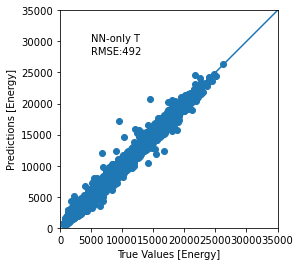

In [36]:
# Use KERAS NN to train a model with temperature as the only weather input
df = pd.read_csv('data\\data_impute.csv')
weather = ['Temperature'] 
X_train, X_test, y_train, y_test, X_col_indice = split_and_normalize(df, 'dummy',weather)
y_pred_NN_onlyT, history_onlyT = NN_keras(X_train, X_test, y_train)
visualize(y_test, y_pred_NN_onlyT, 'NN-only T')

The RMSE is 492, which is only slightly higher than 491 that has all set of weather info. THe result is very good. Considering that obtaining the temperature is much more easier than other parameters, we only use temperature in the final tuning of the keras model. 

### Part IV: Grid search to further improve the neural network model

In [37]:
# Keras model grid search.
def create_model(dense_n = 64):
    '''
    Create a Neural Network model 

    Parameters
    ----------
    dense_n: int
        number of neurons. 
    
    Returns
    -------
    model : 
        A keras neural network model
    '''
    
    model = keras.Sequential([
                            layers.Dense(dense_n, activation='relu', input_shape=[X_train.shape[1]]),
                            layers.Dense(dense_n, activation='relu'),
                            layers.Dense(1)
                            ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model = KerasRegressor(create_model)
param_grid = {'dense_n':[64,32,128], 
              'batch_size':[200, 300],
              'validation_split': [0.2,0.3]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train,
                       epochs=1000,
                       verbose=10,
                       callbacks=[early_stop])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\ZY\anaconda3\envs\ep2\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train on 14085 samples, validate on 3522 samples
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69

Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Best: -261134.440510 using {'batch_size': 300, 'dense_n': 128, 'validation_split': 0.2}


In [7]:
# Save the grid search results.
best_p= {'batch_size': 300, 'dense_n': 128, 'validation_split': 0.2}

The grid search of hyper parameters indicate that we can further increase the neurons in each layer. 

### Part V Save the model to local

In [5]:
# rebuild the model with best parameter, use the keras method to save the model. 
def Final_NN_keras(X_train, X_test, y_train, model_name, best_parameters):
    '''
    Create the final tuned Neural Network model
    Save the model to local. 

    Parameters
    ----------
    X_train : numpy.array
        The train datast
    X_test : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    model_name: string
        The model name to be saved. 
    best_parameters:
        The best hyper parameter obtained from last section.
    
    Returns
    -------
    Y_pred_NN : numpy.array
        The precition on the test datset
    history: 
        The training history
    
    '''
    
    def build_model():
        model = keras.Sequential([
                                layers.Dense(best_parameters['dense_n'], activation='relu', input_shape=[X_train.shape[1]]),
                                layers.Dense(best_parameters['dense_n'], activation='relu'),
                                layers.Dense(1)
                                ])

        optimizer = tf.keras.optimizers.RMSprop(0.001)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
        return model

    model = build_model()
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train,
                        batch_size = best_parameters['batch_size'],
                        epochs=1000, 
                        validation_split = best_parameters['validation_split'], 
                        verbose=1,
                        callbacks=[early_stop])
    
    y_pred_NN = model.predict(X_test).flatten()

    # save the model
    print('Saving model to', model_name)
    model.save(model_name)

    return y_pred_NN, history

# Rebuild the energy signature model, save the key parameters to local. 
def Final_energy_signature(X_train, X_test, y_train, X_col_indice, model_name):
    '''
    Create the final Energy Signature model
    Save the model to local. 

    Parameters
    ----------
    X_train : numpy.array
        The train datast
    X_test : numpy.array
        The test datast
    y_train: numpy.array
        The labels of training data
    model_name: string
        The model name to be saved. 
    X_col_indice: dictionary
        A dictionary that hold the column names of X_train_array and corresponding rows.  
    
    Returns
    -------
    Y_pred_ES : numpy.array
        The precition on the test datset
    
    '''
    
    x = X_train[:,X_col_indice['Temperature']]
    y = y_train
    def ES_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    
    # Training the model.
    p , e = optimize.curve_fit(ES_linear, x, y,
                               bounds =([0.5,3000,-np.inf , -np.inf],[1.5,6000,np.inf, np.inf]))
    
    y_pred_ES = ES_linear(X_test[:,X_col_indice['Temperature']], *p)
    
    # saving the model
    print ('Saving the energy signature model parameters')
    np.savetxt(model_name,p,delimiter=',')
    
    return y_pred_ES


In [8]:
# save the standard scaler
df = pd.read_csv('data\\data_impute.csv')
weather = ['Temperature'] 
X_train, X_test, y_train, y_test, X_col_indice = split_and_normalize(df, 'dummy',weather, if_save_scaler = True)

# Train the NN Model and save to local
y_pred_FinalNN, history_FinalNN = Final_NN_keras(X_train, X_test, y_train, 'models\\Final_NN', best_p)

# Train the Energy Signature model and save to local
y_pred_FinalES = Final_energy_signature(X_train, X_test, y_train, X_col_indice, 'models\\ES_P.csv')

# save the X_test into several parts to avoid the size exceeding 50 MB. 
X_test_rows = X_test.shape[0]
row_int = round(X_test_rows/3)
X_test_p1 = X_test[0:row_int,:]
X_test_p2 = X_test[row_int:2*row_int,:]
X_test_p3 = X_test[2*row_int:,:]

np.savetxt('models\\X_test_p1.csv',X_test_p1,delimiter=',')
np.savetxt('models\\X_test_p2.csv',X_test_p2,delimiter=',')
np.savetxt('models\\X_test_p3.csv',X_test_p3,delimiter=',')

# saving the Y_test and X_col_indice
np.savetxt('models\\y_test.csv',y_test,delimiter=',')
pickle.dump(X_col_indice, open('models\\X_col_indice.pkl', 'wb'))


saving the standard scaler...
Train on 14085 samples, validate on 3522 samples
Epoch 1/1000
14085/14085 [==============================] - 1s 40us/sample - loss: 97845454.4324 - mae: 8253.0967 - mse: 97845440.0000 - val_loss: 99258889.4037 - val_mae: 8261.6572 - val_mse: 99258888.0000
Epoch 2/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 96293740.3962 - mae: 8167.5649 - mse: 96293720.0000 - val_loss: 96794314.6848 - val_mae: 8126.2759 - val_mse: 96794320.0000
Epoch 3/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 92845360.2641 - mae: 7973.9790 - mse: 92845344.0000 - val_loss: 92206038.6780 - val_mae: 7868.2314 - val_mse: 92206032.0000
Epoch 4/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 87095961.8062 - mae: 7642.1113 - mse: 87095968.0000 - val_loss: 85146537.6082 - val_mae: 7456.0146 - val_mse: 85146544.0000
Epoch 5/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 78876867.5783 

14085/14085 [==============================] - 0s 8us/sample - loss: 892642.5050 - mae: 684.6695 - mse: 892642.3125 - val_loss: 972142.8842 - val_mae: 704.5231 - val_mse: 972142.9375
Epoch 42/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 890577.2224 - mae: 683.7294 - mse: 890577.2500 - val_loss: 981612.5635 - val_mae: 706.0824 - val_mse: 981612.5000
Epoch 43/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 888890.1297 - mae: 683.2153 - mse: 888890.0625 - val_loss: 970490.7209 - val_mae: 703.1566 - val_mse: 970490.7500
Epoch 44/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 888354.3216 - mae: 682.0877 - mse: 888354.3750 - val_loss: 968149.6572 - val_mae: 702.2627 - val_mse: 968149.6875
Epoch 45/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 886560.3376 - mae: 681.5236 - mse: 886560.4375 - val_loss: 970409.7336 - val_mae: 702.6499 - val_mse: 970409.8125
Epoch 46/1000
14085/14085 [==

14085/14085 [==============================] - 0s 8us/sample - loss: 855093.6508 - mae: 659.7428 - mse: 855093.6250 - val_loss: 934294.9561 - val_mae: 681.1301 - val_mse: 934295.0000
Epoch 83/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 854902.8284 - mae: 659.7938 - mse: 854902.8125 - val_loss: 933195.3252 - val_mae: 680.6310 - val_mse: 933195.3125
Epoch 84/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 852233.9319 - mae: 658.3592 - mse: 852233.9375 - val_loss: 933550.7458 - val_mae: 680.6349 - val_mse: 933550.6875
Epoch 85/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 852178.0391 - mae: 658.8383 - mse: 852178.1250 - val_loss: 929532.4371 - val_mae: 678.3878 - val_mse: 929532.4375
Epoch 86/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 851591.9109 - mae: 658.0936 - mse: 851591.8125 - val_loss: 929079.8122 - val_mae: 678.3767 - val_mse: 929079.8125
Epoch 87/1000
14085/14085 [==

14085/14085 [==============================] - 0s 8us/sample - loss: 808254.9670 - mae: 635.3535 - mse: 808254.9375 - val_loss: 885948.4933 - val_mae: 657.3850 - val_mse: 885948.5625
Epoch 124/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 806443.7218 - mae: 634.3067 - mse: 806443.8125 - val_loss: 887696.9422 - val_mae: 657.8688 - val_mse: 887696.9375
Epoch 125/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 804638.1544 - mae: 633.8633 - mse: 804638.0625 - val_loss: 887109.6338 - val_mae: 657.8640 - val_mse: 887109.6250
Epoch 126/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 804151.7508 - mae: 633.1949 - mse: 804151.8125 - val_loss: 881255.9826 - val_mae: 655.3081 - val_mse: 881256.0000
Epoch 127/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 802085.9490 - mae: 632.4312 - mse: 802086.0000 - val_loss: 879743.4249 - val_mae: 654.9459 - val_mse: 879743.5000
Epoch 128/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 729500.4540 - mae: 599.5662 - mse: 729500.5000 - val_loss: 812832.3781 - val_mae: 627.0416 - val_mse: 812832.3750
Epoch 165/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 727302.9643 - mae: 597.9494 - mse: 727302.8125 - val_loss: 809324.5704 - val_mae: 625.0583 - val_mse: 809324.5625
Epoch 166/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 724339.2165 - mae: 597.3394 - mse: 724339.1875 - val_loss: 807556.4517 - val_mae: 624.5734 - val_mse: 807556.4375
Epoch 167/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 722060.6647 - mae: 596.1180 - mse: 722060.7500 - val_loss: 805804.6689 - val_mae: 623.7725 - val_mse: 805804.6875
Epoch 168/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 720374.8013 - mae: 594.8435 - mse: 720374.7500 - val_loss: 802921.7078 - val_mae: 622.4644 - val_mse: 802921.6875
Epoch 169/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 603772.0495 - mae: 541.0604 - mse: 603772.0625 - val_loss: 697280.8590 - val_mae: 574.6777 - val_mse: 697280.7500
Epoch 206/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 598914.6917 - mae: 538.9838 - mse: 598914.6875 - val_loss: 700978.4835 - val_mae: 575.8536 - val_mse: 700978.4375
Epoch 207/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 595807.9623 - mae: 536.5102 - mse: 595808.0000 - val_loss: 684544.3431 - val_mae: 569.2294 - val_mse: 684544.3125
Epoch 208/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 592931.7576 - mae: 535.5592 - mse: 592931.7500 - val_loss: 681314.9834 - val_mae: 568.1432 - val_mse: 681315.0000
Epoch 209/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 588522.0967 - mae: 533.4635 - mse: 588522.1250 - val_loss: 682024.8694 - val_mae: 567.8715 - val_mse: 682024.8750
Epoch 210/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 439935.9277 - mae: 456.9490 - mse: 439936.0312 - val_loss: 534797.8835 - val_mae: 493.4852 - val_mse: 534797.8750
Epoch 247/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 436489.0081 - mae: 454.7934 - mse: 436489.0625 - val_loss: 531367.1038 - val_mae: 491.6709 - val_mse: 531367.1250
Epoch 248/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 432446.1623 - mae: 451.9460 - mse: 432446.1875 - val_loss: 529931.5619 - val_mae: 491.7753 - val_mse: 529931.5625
Epoch 249/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 429184.5227 - mae: 450.8829 - mse: 429184.5000 - val_loss: 523276.9578 - val_mae: 487.1098 - val_mse: 523276.9688
Epoch 250/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 424873.2379 - mae: 447.9576 - mse: 424873.2188 - val_loss: 520344.2021 - val_mae: 485.1999 - val_mse: 520344.2188
Epoch 251/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 323780.1074 - mae: 384.7258 - mse: 323780.0625 - val_loss: 422399.3568 - val_mae: 431.5803 - val_mse: 422399.3125
Epoch 288/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 321760.7732 - mae: 383.0626 - mse: 321760.7812 - val_loss: 419918.4016 - val_mae: 430.1581 - val_mse: 419918.3438
Epoch 289/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 319976.2911 - mae: 381.8987 - mse: 319976.3125 - val_loss: 416332.9015 - val_mae: 428.0951 - val_mse: 416332.9062
Epoch 290/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 318285.7721 - mae: 380.3672 - mse: 318285.7500 - val_loss: 414934.1812 - val_mae: 427.0366 - val_mse: 414934.2188
Epoch 291/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 316462.1130 - mae: 378.9704 - mse: 316462.0938 - val_loss: 413431.0146 - val_mae: 426.4749 - val_mse: 413431.0312
Epoch 292/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 264080.7881 - mae: 341.8315 - mse: 264080.8438 - val_loss: 365520.1024 - val_mae: 399.2448 - val_mse: 365520.1250
Epoch 329/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 263290.7439 - mae: 340.8777 - mse: 263290.7812 - val_loss: 363807.0655 - val_mae: 397.6462 - val_mse: 363807.0625
Epoch 330/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 262015.7521 - mae: 340.0764 - mse: 262015.7500 - val_loss: 362154.9900 - val_mae: 397.1292 - val_mse: 362155.0000
Epoch 331/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 261916.3603 - mae: 339.8302 - mse: 261916.3594 - val_loss: 362131.5721 - val_mae: 397.0958 - val_mse: 362131.5625
Epoch 332/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 260057.6448 - mae: 338.5442 - mse: 260057.6562 - val_loss: 361838.5319 - val_mae: 397.2809 - val_mse: 361838.5625
Epoch 333/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 225950.7952 - mae: 313.5317 - mse: 225950.8125 - val_loss: 330831.4614 - val_mae: 379.0461 - val_mse: 330831.4688
Epoch 370/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 224471.9203 - mae: 311.6223 - mse: 224471.9219 - val_loss: 330306.9392 - val_mae: 380.5093 - val_mse: 330306.9375
Epoch 371/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 224380.5576 - mae: 311.4191 - mse: 224380.5781 - val_loss: 330113.0119 - val_mae: 377.8481 - val_mse: 330112.9688
Epoch 372/1000
14085/14085 [==============================] - 0s 10us/sample - loss: 222512.0805 - mae: 310.3985 - mse: 222512.1094 - val_loss: 327774.9111 - val_mae: 377.2420 - val_mse: 327774.9375
Epoch 373/1000
14085/14085 [==============================] - 0s 10us/sample - loss: 222282.1942 - mae: 310.1434 - mse: 222282.1875 - val_loss: 326779.9473 - val_mae: 377.8362 - val_mse: 326779.9688
Epoch 374/1000
14085/14

14085/14085 [==============================] - 0s 8us/sample - loss: 196403.3898 - mae: 289.9068 - mse: 196403.3594 - val_loss: 302117.0141 - val_mae: 363.0353 - val_mse: 302117.0000
Epoch 411/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 195634.8833 - mae: 289.1689 - mse: 195634.8906 - val_loss: 304544.9044 - val_mae: 363.7908 - val_mse: 304544.9062
Epoch 412/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 195343.1746 - mae: 289.4245 - mse: 195343.1719 - val_loss: 300034.1732 - val_mae: 360.8331 - val_mse: 300034.1562
Epoch 413/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 194629.0057 - mae: 288.1497 - mse: 194629.0156 - val_loss: 299199.7825 - val_mae: 361.0769 - val_mse: 299199.7812
Epoch 414/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 193614.3641 - mae: 287.5309 - mse: 193614.3594 - val_loss: 301520.3058 - val_mae: 364.1652 - val_mse: 301520.3125
Epoch 415/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 172729.8196 - mae: 270.0303 - mse: 172729.8125 - val_loss: 279455.5434 - val_mae: 350.2722 - val_mse: 279455.5312
Epoch 452/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 172433.1221 - mae: 270.1790 - mse: 172433.0938 - val_loss: 279140.8747 - val_mae: 348.7253 - val_mse: 279140.8438
Epoch 453/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 171766.2100 - mae: 268.5928 - mse: 171766.2031 - val_loss: 281589.8154 - val_mae: 349.9457 - val_mse: 281589.8125
Epoch 454/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 171271.6931 - mae: 268.3928 - mse: 171271.7031 - val_loss: 278619.8080 - val_mae: 348.6935 - val_mse: 278619.8438
Epoch 455/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 170751.2930 - mae: 268.0996 - mse: 170751.2969 - val_loss: 277438.0671 - val_mae: 347.8141 - val_mse: 277438.0625
Epoch 456/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 153702.3743 - mae: 252.6543 - mse: 153702.3750 - val_loss: 265078.5157 - val_mae: 341.3289 - val_mse: 265078.4688
Epoch 493/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 153783.3557 - mae: 252.7216 - mse: 153783.3750 - val_loss: 265171.1222 - val_mae: 339.7567 - val_mse: 265171.1250
Epoch 494/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 153062.6398 - mae: 252.0634 - mse: 153062.6562 - val_loss: 264129.9919 - val_mae: 338.8776 - val_mse: 264129.9688
Epoch 495/1000
14085/14085 [==============================] - 0s 9us/sample - loss: 152921.0852 - mae: 251.2228 - mse: 152921.0781 - val_loss: 264490.9296 - val_mae: 340.0616 - val_mse: 264490.9062
Epoch 496/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 152404.1617 - mae: 250.9919 - mse: 152404.1562 - val_loss: 266630.6015 - val_mae: 339.9572 - val_mse: 266630.5938
Epoch 497/1000
14085/1408

14085/14085 [==============================] - 0s 8us/sample - loss: 139365.1337 - mae: 238.7974 - mse: 139365.1250 - val_loss: 255030.7290 - val_mae: 334.0731 - val_mse: 255030.7344
Epoch 534/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 139151.4568 - mae: 237.6964 - mse: 139151.4375 - val_loss: 261825.7808 - val_mae: 338.0367 - val_mse: 261825.7812
Epoch 535/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 139363.8150 - mae: 238.0678 - mse: 139363.7969 - val_loss: 255702.4369 - val_mae: 333.5934 - val_mse: 255702.4375
Epoch 536/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 138438.8642 - mae: 237.1254 - mse: 138438.8438 - val_loss: 258207.0044 - val_mae: 334.2573 - val_mse: 258207.0312
Epoch 537/1000
14085/14085 [==============================] - 0s 8us/sample - loss: 138578.7662 - mae: 237.2271 - mse: 138578.7656 - val_loss: 257174.8464 - val_mae: 333.7626 - val_mse: 257174.8594
Epoch 538/1000
14085/1408

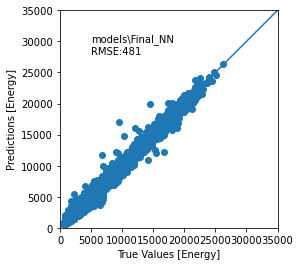

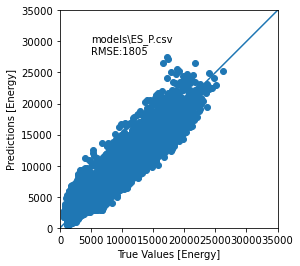

In [9]:
# Visualize the final trained model.
visualize(y_test, y_pred_FinalNN, 'models\\Final_NN')
visualize(y_test, y_pred_FinalES, 'models\\ES_P.csv')

The neural network models has much better performance than the energy signature model. The neural network model has taken into account of time, which is a very important factor. It is not surprising that neural network model can produce better result. 

We need to make sure the trained neural network model is **not overfitted**. We use the following cell to show the traing history. As we can see from the figure, both the training loss and validation loss decrease over time. It means that the model is not overfitted.  

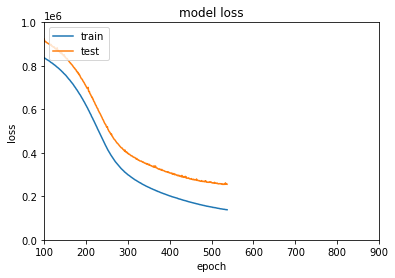

In [10]:
def plot_train_history(history):
    '''
    Visualize the train history. 

    Parameters
    ----------
    history : 
        The training history
    '''
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlim(100,900)
    plt.ylim(0, 1000000)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history_FinalNN)

## Reload the Model
In the following section, we test if we can reload the trained models and use the reconstructed model to make predicitons. 

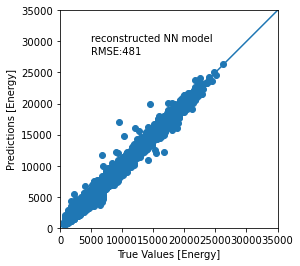

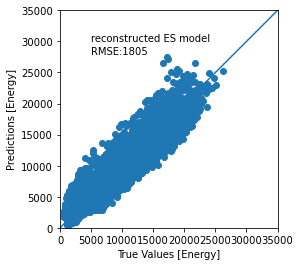

In [12]:
# load the scaler/NN model/ES model
recons_scalser = pickle.load(open('models\\scaler.pkl','rb'))
recons_NN = load_model("models\\Final_NN")

ESmodel_p = np.loadtxt('models\\ES_P.csv', delimiter=',')
def ES_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])


# reload X_test, Y_test, X_col_indice
X_reload_p1 = np.loadtxt('models\\X_test_p1.csv', delimiter=',')
X_reload_p2 = np.loadtxt('models\\X_test_p2.csv', delimiter=',')
X_reload_p3 = np.loadtxt('models\\X_test_p3.csv', delimiter=',')
X_reload = np.append(X_reload_p1, X_reload_p2, axis =0)
X_reload = np.append(X_reload, X_reload_p3, axis =0)

#X_reload = np.loadtxt('models\\X_test.csv', delimiter=',')
y_reload = np.loadtxt('models\\y_test.csv', delimiter=',')
X_col_reload = pickle.load(open('models\\X_col_indice.pkl','rb'))

# Make predictions
y_pred_reconsES = ES_linear(X_reload[:,X_col_reload['Temperature']], *ESmodel_p)
y_pred_reconsNN = recons_NN.predict(X_reload)

# visualization
visualize(y_reload, y_pred_reconsNN, 'reconstructed NN model')
visualize(y_reload, y_pred_reconsES, 'reconstructed ES model')


As we can see, the reloaded model produced the same results. The neural network model have achieved much better performance than the reference case.

## Conclusion
In this project, we defined a energy prediction problem and collected the dataset that can be used to train a machine learning model. We have defined two methods that can be used to process the time-related data. We can treat time-related data as either categorical value or convert them through trigonometric functions. We further built four three machine learning models and a commonly used 'Energy Signature' models. In total, eight scenarios were compared and the results indicated that the combination of neural network and treating time-related data as categorical value yield the best results. 
<br /> 
In consideration of real-world applications, some weather information is difficult to obtain. We used the XGBoost to show feature importance and decided only use temperature in the input data. We retrained the neural network model and obtained satisfactory results. 
<br /> 
Grid search method is further used to tune the hyper parameters in the neural network model. We further rebuilt the model with tuned hyper parameters and checked the training history. There is no sign of overfittning. 
<br /> 
In the final section, we saved the trained model as well as the energy signature model. These models are further used in an web application (check readme file to find how to execute the web application). 


## Further Improvement
Recurrent neural network (RNN) is known suitable for time-series data. It has the potential to yield even better prediction results. When using RNN, we need to split the dataset into consecutive parts. So the test set is usually the most up-to-date energy consumption. The split of dataset makes it hard to catch the long-term variance. For example, some users might have decided to use some energy-efficient measures recently. This kind of infomation is only in the test dataset and is blind to the training dataset. This is a potential disadvantage of using RNN in this paricular problem. However, it is worth trying RNN in the future.